In [1]:
%pylab inline
from parcels import FieldSet, ParticleSet, ScipyParticle, JITParticle, Variable
from parcels import AdvectionRK4, plotTrajectoriesFile
import numpy as np
from datetime import timedelta as delta
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


### Code to check c-grid definition NEMO vs MITgcm

Make three fieldsets (radial rotation example):

- NEMO: f-points in northeast, u-points in the east, v-points in the north
- MIT: f-points in the southwest, u-points in the west, v-points in the south
- corrected: like MIT, but u shifted in j-direction, v shifted in i-direction

In [2]:
#make fieldsets based on NEMO c-grid, MITgcm c-grid and an MITgcm c-grid that is corrected

xdim=ydim=201
a = b = 20000  # domain size
lon = np.linspace(-a/2, a/2, xdim, dtype=np.float32)
lat = np.linspace(-b/2, b/2, ydim, dtype=np.float32)
dx, dy = lon[2]-lon[1], lat[2]-lat[1]
omega = 2 * np.pi / delta(days=1).total_seconds()

def calc_r_phi(ln, lt):
    return np.sqrt(ln**2 + lt**2), np.arctan2(ln, lt)

def calculate_UVR(lat,lon,dx,dy,omega,cgrid='nemo'):
    U = np.zeros((lat.size, lon.size), dtype=np.float32)
    V = np.zeros((lat.size, lon.size), dtype=np.float32)
    R = np.zeros((lat.size, lon.size), dtype=np.float32)
    
    for i in range(lon.size):
        for j in range(lat.size):
            r, phi = calc_r_phi(lon[i], lat[j])
            R[j, i] = r
            if cgrid=='nemo':
                r, phi = calc_r_phi(lon[i]-dx/2, lat[j])
                V[j, i] = -omega * r * np.sin(phi)
                r, phi = calc_r_phi(lon[i], lat[j]-dy/2)
                U[j, i] = omega * r * np.cos(phi)
            if cgrid=='mit':
                r, phi = calc_r_phi(lon[i]+dx/2, lat[j])
                V[j, i] = -omega * r * np.sin(phi)
                r, phi = calc_r_phi(lon[i], lat[j]+dy/2)
                U[j, i] = omega * r * np.cos(phi)
    
    return U, V, R

#save NEMO fieldset 
U,V,R = calculate_UVR(lat,lon,dx,dy,omega,cgrid='nemo')
data = {'U': U, 'V': V, 'R': R}
dimensions = {'lon': lon, 'lat': lat}
fieldset_NEMOstyle = FieldSet.from_data(data, dimensions, mesh='flat')
fieldset_NEMOstyle.U.interp_method = 'cgrid_velocity'
fieldset_NEMOstyle.V.interp_method = 'cgrid_velocity'

#save MITgcm fieldset 
U,V,R = calculate_UVR(lat,lon,dx,dy,omega,cgrid='mit')
data = {'U': U, 'V': V, 'R': R}
dimensions = {'lon': lon, 'lat': lat}
fieldset_MITstyle = FieldSet.from_data(data, dimensions, mesh='flat')
fieldset_MITstyle.U.interp_method = 'cgrid_velocity'
fieldset_MITstyle.V.interp_method = 'cgrid_velocity'

#corrected MITgcm fieldset
UU = np.zeros((lat.size, lon.size), dtype=np.float32)
VV = np.zeros((lat.size, lon.size), dtype=np.float32)
UU[1:,:]=U[0:-1,:] #shift grids of U and V by adding row/column of zeros 
VV[:,1:]=V[:,0:-1] #(U in j-direction, V in i-direction)
data = {'U': UU, 'V': VV, 'R': R}
dimensions = {'lon': lon, 'lat': lat}
fieldset = FieldSet.from_data(data, dimensions, mesh='flat')
fieldset_corrected = FieldSet.from_data(data, dimensions, mesh='flat')
fieldset_corrected.U.interp_method = 'cgrid_velocity'
fieldset_corrected.V.interp_method = 'cgrid_velocity'

### Run same particle in three different fields

Second figure shows that without changing UV grid, c-grid definition of the MITgcm gives different results. 

In [3]:
def UpdateR(particle, fieldset, time):
    particle.radius = fieldset.R[time, particle.depth, particle.lat, particle.lon]

class MyParticle(ScipyParticle):
    radius = Variable('radius', dtype=np.float32, initial=0.)
    radius_start = Variable('radius_start', dtype=np.float32, initial=fieldset_NEMOstyle.R)

pset = ParticleSet(fieldset_NEMOstyle, pclass=MyParticle, lon=0, lat=4e3, time=0)

output = pset.ParticleFile(name='Cgrid_NEMOstyle.nc', outputdt=delta(hours=1))
pset.execute(pset.Kernel(UpdateR) + AdvectionRK4,
             runtime=delta(hours=24),
             dt=delta(minutes=5),  
             output_file=output)
output.close()

class MyParticle(ScipyParticle):
    radius = Variable('radius', dtype=np.float32, initial=0.)
    radius_start = Variable('radius_start', dtype=np.float32, initial=fieldset_MITstyle.R)

pset = ParticleSet(fieldset_MITstyle, pclass=MyParticle, lon=0, lat=4e3, time=0)

output = pset.ParticleFile(name='Cgrid_MITstyle.nc', outputdt=delta(hours=1))
pset.execute(pset.Kernel(UpdateR) + AdvectionRK4,
             runtime=delta(hours=24),
             dt=delta(minutes=5),  
             output_file=output)
output.close()

class MyParticle(ScipyParticle):
    radius = Variable('radius', dtype=np.float32, initial=0.)
    radius_start = Variable('radius_start', dtype=np.float32, initial=fieldset_corrected.R)

pset = ParticleSet(fieldset_corrected, pclass=MyParticle, lon=0, lat=4e3, time=0)

output = pset.ParticleFile(name='Cgrid_corrected.nc', outputdt=delta(hours=1))
pset.execute(pset.Kernel(UpdateR) + AdvectionRK4,
             runtime=delta(hours=24),
             dt=delta(minutes=5),  
             output_file=output)
output.close()

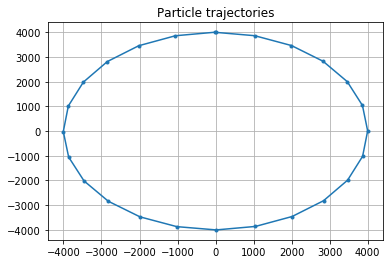

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [4]:
plotTrajectoriesFile('Cgrid_NEMOstyle.nc')

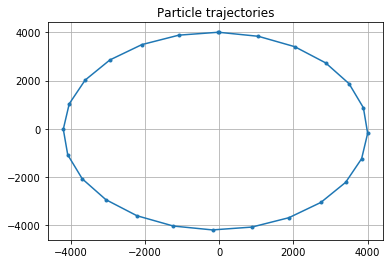

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [5]:
plotTrajectoriesFile('Cgrid_MITstyle.nc')

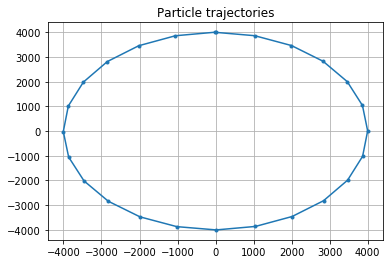

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [6]:
plotTrajectoriesFile('Cgrid_corrected.nc')